# MNIST
Author: Akaam Shamerany \[@alpharoah GitHub\]<br>Helpful resources: Hands On Machine Learning with Scikit-Learn, Keras and Tensorflow - Aurélien Géron

<br>In this notebook, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

<br>Scikit-Learn provides an easy way to download this dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn have similar dictionary structure including

* A `DESCR` key describing the Datasets
* A `data key` containing an array with one row per instance and one column per feature
* A `target key` containing an array with the labels

In [2]:
#Lets look at the arrays:

X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28x28 pixels and each feature simply represents one pixel's intensity from 0 to 255 (white to black)

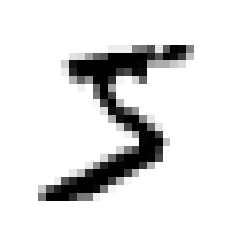


5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 



some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print(f"\n{y[0]}") #Shows that this image is infact 5
y = y.astype(np.uint8) #The output is a string, let's change it to type int (uint8)

If you read our last Learning project, the housing model, we said that we should always create a test set and set it aside before inspecting the data closely. This MNIST dataset is actually already split into a training set and a test set (6:1)

In [4]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:] #The training set is already shuffled for us

## Training a Binary Classifier

Let's simplify the problem and solve it so we can detect 5 and not 5. Let's create target vectors for this classification task:

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

array([ True, False, False, ...,  True, False, False])

Let's pick a classifier and train it. A good place to start is with `Stochastic Gradient Descent (SGD)` classifier.

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

And now it's been trained! you can use it detect images of the number 5:

In [7]:
sgd_clf.predict([some_digit]) # guessed that our image represents 5 (True)

array([ True])

## Performance Measures

Evaluating classification is significantly harder than evaluating a regressor. There are many performance measures available.

<br>

### Measuring Accuracy using Cross-Validation

<br>Let's use `cross_val_score()` to evaluate our SGDClassifier model using K-fold cross-validation, using 3 folds.

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

above 95% accuracy! Well, this is because only about 10% of the image are 5s, so if you always guess that an image is __*not*__ a 5, you will be right about it 90% of the time.

<br>This is why accuracy is generally not the best way to measure performance for classifiers, especially when you are dealing with skewed datasets (i.e. when some classes are much more frequent than others)

### Confusion Matrix

<br>Better way to measure performance of a classifier is to look at the confusion matrix.

<br>The idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look into the 5th row and the 3rd column of the confusion matrix.

<br>To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual target. You could make predicitons on the test set, but let's keep it untouched for now. Let's use `cross_val_predict()`

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

Now we are ready to get the confusion matrix using the `confusion_matrix()` function. We just need to pass it the target classes (y_train_5) and the predicted classes (y_train_pred)

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

Each row represents a class and each column represents a predicted class. The first row of the matrix considers non-5 images (negative class): 53115 of them were correctly classified as non-5 (true negatives), while remaining 1464 were wrongly classified as 5s (false positives). The second rrow considers the images of 5s (positive class). 916 were wrongly classified as non-5's (false negatives) and 4505 were correctly classified as 5s (true positives). A perfect classifier would have only true positves and true negatives, so its confusion matrix would have non zero values only on its main diagonal.

In [11]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

This is cool, but somteimes we may prefer a more concise metrix. Like the accuracy of the positive predictions, called __*precision*__ of the classifier

<br> The equation for this is 
<br>precision = TP/(TP+FP)

<br>Where TP is true positives and FP is false positives

But if we have only a single positive prediction the precision would be 1/1 = 100%. This is not very useful and would ignore all but one positive instance. So precision is typically used along with another metix named recall (or sensitivity/true positive rate)

<br> The equation for this is 
<br>precision = TP/(TP+FN)

<br>Where TP is true positives and FP is false negatives

<img src="./images/confusion_matrix.png">

This is an easier way to understand the confusion matrix

## Precision and Recall

In [12]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7547327860613168
0.8310274857037447


Now when it claims an image represents a 5, it is correct 75% of the time and moreover, it detects 83% of the 5s.

<br> it is often convenient to combine precision and recall into a single metric called the F_1 score. The F_1 (also known as the __*harmonic mean*__) gives much more weight to low values and as a result, the classifier will only get a high F_1 score if both recall and precision are high. The equation for F_1 is:

<img src="./images/F_1equation.png">


In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.791044776119403

F_1 score favours calssifiers that have similar precision and recall. But this may not be what we want. In some contexts you might mostly care about precision, for example if you trained a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few bad videos show up in your product.

<br>On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (There will be a few false alarms, but it will make sure that all shoplifters get caught)

<br>However, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called precision/recall tradoff  

## Precision/recall tradeoff

<br>

To understand this tradeoff, let's look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a `decision function`. If that score is greater than threshhold, it assigns the instance to the positive class, or else it assigns it to the negative class.

<img src="./images/SGDClassifier_threshold.png">

<br>This picture shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the `decision threshhold` is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshhold, and one false positive (actually a 6). Therefore, with that threshhold, the precision is 80% (4/5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4/6). Now if you raise the threshhold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshhold increases recall and reduces precision

<br>Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions, Instead of calling the classifier's `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method. Let's raise the threshold

In [15]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred) #Confirms that raising the threshhold decreases recall

[False]


The image actually represents a 5, and the classifier detects it when the thresh is 0,0 but it misses it when the threshold is increased to 8000. 

<br>We can decide a threshold by first getting the scores of all instances in the training set using the `cross_val_predict()` function againm but this time specifying that you want it to return decision scores instead of predicitons:

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# now let's compute precision and recall for all possible thresholds using the precision_recall_curve() function

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Let's also plot precision and recall as functions of the threshold value:

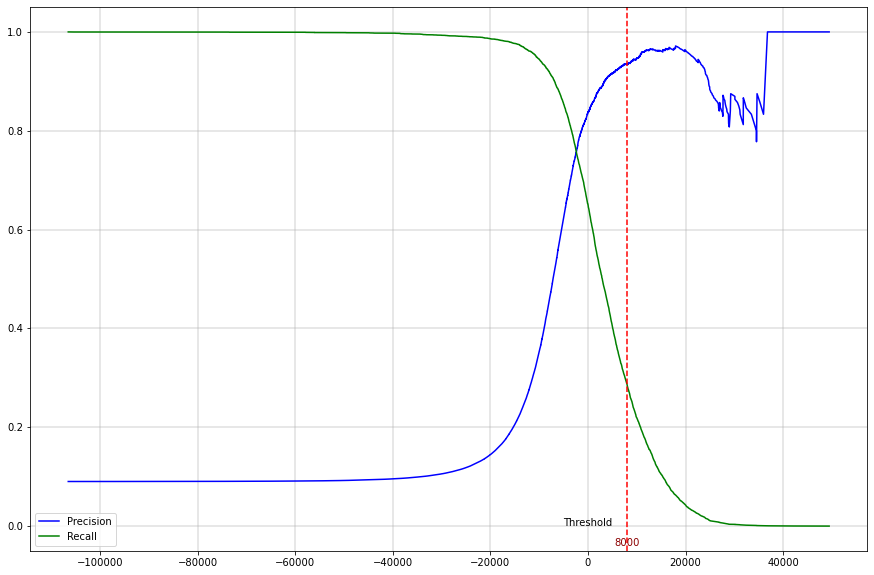

In [54]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
   
    plt.axvline(8000, color="r", linestyle="--")
    plt.annotate("8000", xy=(8000,-0.04), color="darkred", horizontalalignment="center")

    plt.annotate("Threshold", xy=(0,0), horizontalalignment="center")

    fig = plt.gcf()
    fig.set_size_inches(15,10)
    plt.grid(alpha=0.3, linestyle="-", linewidth=2)
    plt.legend(("Precision", "Recall"))

    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The graph shows the behaviour of the precision and recall when the threshold is increased (or decreased)

<br>Another way to select a good precision/recall tradeoff is to plot precision directly against recall:

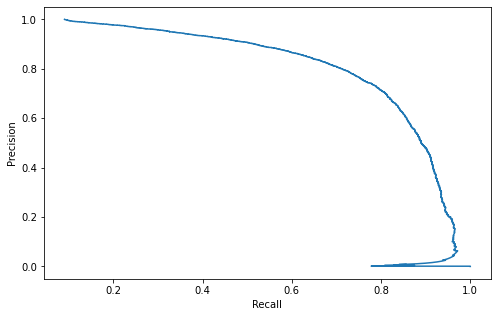

In [78]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions, recalls)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    fig = plt.gcf()
    fig.set_size_inches(8,5)
    

plot_precision_vs_recall(precisions, recalls)
plt.show()

You can see that precision really starts to fall sharply aorund 80% recall. You will probably want to select a precision/recall tradeoff just before that drop - for example, at around 60% recall. The choice for all this depends on what we want. 

<br>Now we have these graphs, suppose we deciide to aim for 90% precision. We need to look at the first graph and then use a threshold of about 8000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (`np.argmax()`)

In [79]:
threshold_90_precision = thresholds[np.argmax(precisions > 0.90)]

print(f"Scores at threshold: {threshold_90_precision}\n")

#To make predicitons, instead of calling the classifiers predict() method, we can just run this code

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(f"Precision Score: {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall Score: {recall_score(y_train_5, y_train_pred_90)}")


Scores at threshold: 3370.0194991439557

Precision Score: 0.9000345901072293
Recall Score: 0.4799852425751706


Awesome! Now we have 90% precision! It's fairly easy to create a classiier with virtually an precision we want: you just set a high enough threshold. Well, remember a high precision is not useful is its recall is too low

## ROC Curve

<br> The __*receiver operating characteristic*__ (ROC) curve is anohter common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision vs recall, the ROC curve plots the __true positive rate__ (another name for recall) against the __false positive rate__. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to (1 - true negative rate), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called __specificity__. Hence the ROC curve plots __sensitivity__ (recall) vs 1 - __specificity__ 

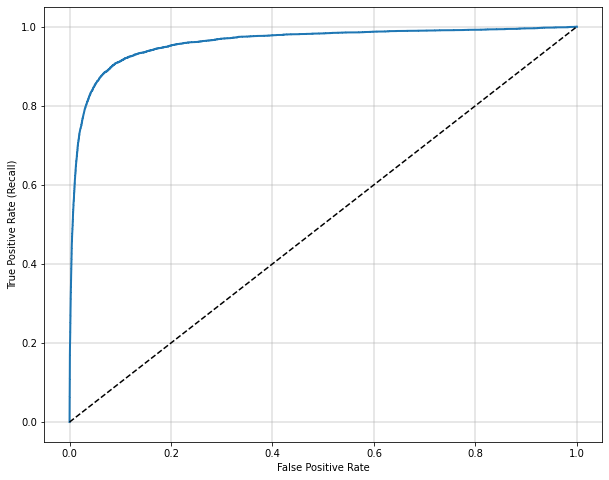

In [84]:
# to plot the ROC curve, we need to compute TPR and FPR for various threshold values, using roc_curve() function

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# plot graph

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

    plt.grid(alpha=0.3, linestyle="-", linewidth=2)

    fig = plt.gcf()
    fig.set_size_inches(10,8)

plot_roc_curve(fpr, tpr)


We can observe a tradeoff here: the higher the recall (TPR), the more false positives (FPR) the classifier prodcues.
<br>The dotted line represnts the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

<br>One way to compare classifiers is to measure the __area under the curve__ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

In [85]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


Since ROC is so similiar to precision/recall (PR). You should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.
<br>For example,looking at the previous ROC curv (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for imporvement (the curve could be closer to the top-right corner)

<br>
<br>Let's train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to the SGDClassifier. 